In this notebook, we try implementing PPO that uses the discrete version of the game.

In [1]:
# If you haven't installed
# !pip install numpy
# !pip install swig
# !pip install gymnasium[box2d]
# !pip install matplotlib
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

In [2]:
env = gym.make('CarRacing-v2', continuous=False) # continuous=True indicates that the action spaces are continuous values, rather than discrete. Because we are testing PPO that works with continuous values
print("Observation space: ", env.observation_space) # (low, high, shape, dtype)
print("Action space: ", env.action_space) # (low, high, shape, dtype) 
# Space => 96x96 RGB image, hence (96, 96, 3) shape, with pixel values ranging from 0-255

Observation space:  Box(0, 255, (96, 96, 3), uint8)
Action space:  Discrete(5)


(96, 96, 3)


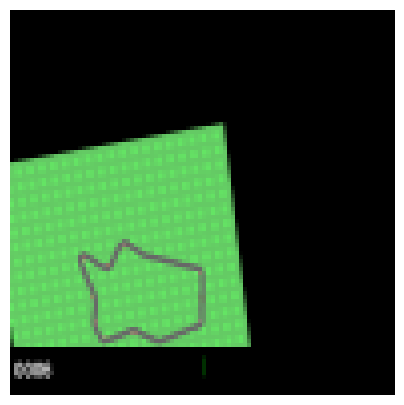

In [3]:
# Initial state
observation, info = env.reset()
print(observation.shape)

plt.figure(figsize=(5, 5))
plt.imshow(observation)
plt.axis('off')
plt.show()

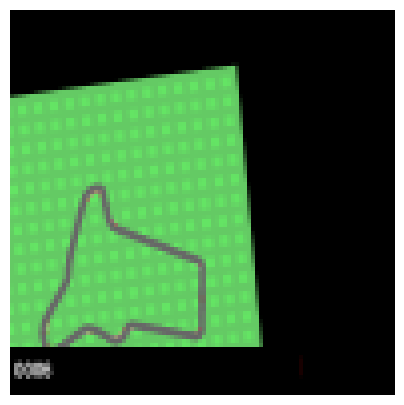

In [4]:
import matplotlib
from IPython.display import HTML
import matplotlib.animation as animation

frames = []
go_straight = 0
env.reset() # reset the environment so we always make sure to start from the beginning
for i in range(50):
    # test see for the first 50 initial frames
    s, r, terminated, truncated, info = env.step(go_straight)
    frames.append(s)
    
# Create animation
fig = plt.figure(figsize=(5, 5))
plt.axis('off')
im = plt.imshow(frames[0])
def animate(i):
    im.set_array(frames[i])
    return im,
anim = matplotlib.animation.FuncAnimation(fig, animate, frames=len(frames))
HTML(anim.to_jshtml())

# Conclusion: since the first 50 frames/steps involve the camera zooming, therefore we will not use the first 50 steps.

### Why PPO
The main reason behind using PPO is that it is a very robust algorithm. Another positive point for PPO is that it can be adapted to be Asynchronous, that gives us the possibility of multiple parallel environments to improve convergence by reducing the correlation between samples which is a problem of DRL. (Have in mind that PPO is not the only algorithm adaptable to Asynchronous Learning).

### DQN (2014)
Tends to be unstable (offline method, which means it learns from data from previous policy), use value iteration bootstrapping. Data efficient, but unstable.

### TRPO (2015)
To improve DQN, come up with policy optimization method (take the action that maximize expected (new policy distribution / old policy distribution)*advantage)

### PPO (2017)
Simplify TRPO to be quicker, still use policy optimization, but simplified the math.

In [5]:
# To standardize with DQN training, we are gonna convert RGB representation to gray-scale, crop to 84x84 region, and selects action on every k-th frame instead of every frame.

import cv2
from gymnasium import spaces

def preprocess(img):
    img = img[:84, 6:90] # CarRacing-v2-specific cropping
    # img = cv2.resize(img, dsize=(84, 84)) # or you can simply use rescaling
    
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) / 255.0
    return img

class ImageEnv(gym.Wrapper):
    def __init__(
        self,
        env,
        skip_frames=4,
        stack_frames=4,
        initial_no_op=50,
        **kwargs
    ):
        super(ImageEnv, self).__init__(env, **kwargs)
        self.initial_no_op = initial_no_op
        self.skip_frames = skip_frames
        self.stack_frames = stack_frames
        self.observation_space = spaces.Box(low=0, high=255,
                                            shape=(4, 84, 84), dtype=np.float64)
    
    def reset(self, seed=None):
        # Reset the original environment.
        s, info = self.env.reset(seed=seed)
        no_op = 0
        # Do nothing for the next `self.initial_no_op` steps
        for i in range(self.initial_no_op):
            s, r, terminated, truncated, info = self.env.step(no_op)
        
        # Convert a frame to 84 X 84 gray scale one
        s = preprocess(s)

        # The initial observation is simply a copy of the frame `s`
        self.stacked_state = np.tile(s, (self.stack_frames, 1, 1))  # [4, 84, 84]
        # print(self.stacked_state.shape)
        return self.stacked_state, info
    
    def step(self, action):
        # We take an action for self.skip_frames steps
        reward = 0
        for _ in range(self.skip_frames):
            s, r, terminated, truncated, info = self.env.step(action)
            reward += r
            if terminated or truncated:
                break

        # Convert a frame to 84 X 84 gray scale one
        s = preprocess(s)

        # Push the current frame `s` at the end of self.stacked_state
        self.stacked_state = np.concatenate((self.stacked_state[1:], s[np.newaxis]), axis=0)
        # print(self.stacked_state.shape)

        return self.stacked_state, reward, terminated, truncated, info

The shape of an observation:  (4, 84, 84)


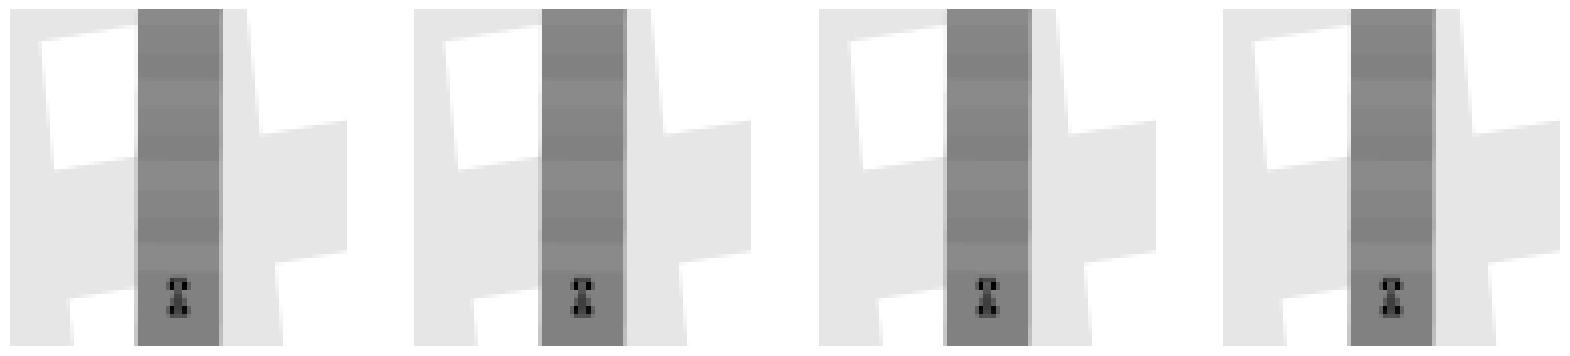

In [6]:
# See the result of processsing
env = gym.make('CarRacing-v2', continuous=False)
env = ImageEnv(env)

s, _ = env.reset()
print("The shape of an observation: ", s.shape)

# modified observation
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    axes[i].imshow(s[i], cmap='gray')
    axes[i].axis('off')
plt.show()

In [7]:
# If you haven't installed
# !pip install stable_baselines3
from stable_baselines3.common.env_checker import check_env
# It will check your custom environment and output additional warnings if needed
check_env(env)

/Users/pangyen/anaconda3/envs/carRacing/lib/python3.10/site-packages/stable_baselines3/common/env_checker.py:54: UserWarning: It seems that your observation  is an image but its `dtype` is (float64) whereas it has to be `np.uint8`. If your observation is not an image, we recommend you to flatten the observation to have only a 1D vector
  warnings.warn(


In [8]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import VecFrameStack
from stable_baselines3.common.evaluation import evaluate_policy
import os


In [9]:
import torch as th
observation, info = env.reset()
log_path = os.path.join('Training', 'Logs')
# use non-stationary adam optimizer to prevent policy collapse, according to paper, betas = 0.99, 0.997, or 0.999
model = PPO("CnnPolicy", env, verbose=1, tensorboard_log=log_path, policy_kwargs=dict(normalize_images=False, optimizer_kwargs=dict(betas=(0.99,0.99))))
# model = PPO("CnnPolicy", env, verbose=1, tensorboard_log=log_path, policy_kwargs=dict(normalize_images=False))
# model.learn(total_timesteps=100) # Increase the timesteps to increase training complexity, but hence increase training time
# model.save("ppo_CarRacing")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [10]:
# improving on target network
def evaluate(n_evals=5):
    eval_env = gym.make('CarRacing-v2', continuous=False)
    eval_env = ImageEnv(eval_env)
    
    scores = 0
    for i in range(n_evals):
        (s, _), done, ret = eval_env.reset(), False, 0
        while not done:
            action, _states = model.predict(s)
            s, r, terminated, truncated, info = eval_env.step(action)
            scores += r
            done = terminated or truncated
    return np.round(scores / n_evals, 4)

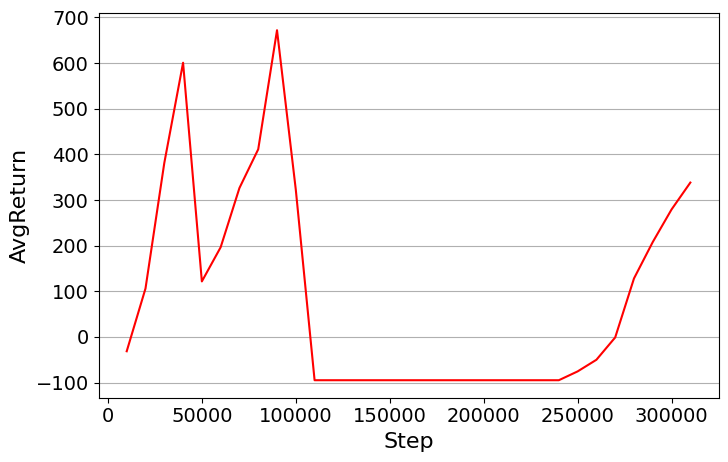

In [11]:
from IPython.display import clear_output
s, _ = env.reset()
history = {'Step': [], 'AvgReturn': []}
eval_interval = 10000
total_steps = 0
max_steps = 300000 # modify this to how many steps to train on
timesteps_per_train = 10000
while True:
    model.learn(total_timesteps=timesteps_per_train)
    total_steps += timesteps_per_train
    
    print(f"Step: {total_steps}, Return: {evaluate()}")
    if total_steps % eval_interval == 0:
        print(f"---start evaluation for step {total_steps}---")
        ret = evaluate() # evaluate the average return of 5 episodes
        print("---end evaluation---")
        history['Step'].append(total_steps)
        history['AvgReturn'].append(ret)
        
        clear_output()
        plt.figure(figsize=(8, 5))
        plt.plot(history['Step'], history['AvgReturn'], 'r-')
        plt.xlabel('Step', fontsize=16)
        plt.ylabel('AvgReturn', fontsize=16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.grid(axis='y')
        plt.show()
        
        model.save(f"ppo_CarRacing discrete t-{total_steps / timesteps_per_train}")
    
    if total_steps > max_steps:
        break

In [12]:
eval_env = gym.make('CarRacing-v2', continuous=False, render_mode='rgb_array')
eval_env = ImageEnv(eval_env)
frames = []
(s, _), done, ret = eval_env.reset(), False, 0
scores = 0
while not done:
    frames.append(eval_env.render())
    action, _states = model.predict(s)
    s, r, terminated, truncated, info = eval_env.step(action)
    scores += r
    done = terminated or truncated

In [13]:
print(scores)

361.08108108107473


In [14]:
def animate(imgs, video_name, _return=True):
    import cv2
    import os
    import string
    import random
    
    if video_name is None:
        video_name = ''.join(random.choice(string.ascii_letters) for i in range(18)) + '.webm'
    height, width, layers = imgs[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'VP90')
    video = cv2.VideoWriter(video_name, fourcc, 10, (width, height))
    
    for img in imgs:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        video.write(img)
    video.release()
    if _return:
        from IPython.display import Video
        return Video(video_name)
animate(frames, "CarRacing.webm")

OpenCV: FFMPEG: tag 0x30395056/'VP90' is not supported with codec id 167 and format 'webm / WebM'


In [15]:
# Example of loading model
loaded_model = PPO.load("ppo_CarRacing discrete t-1.0")
eval_env = gym.make('CarRacing-v2', continuous=False, render_mode='human')
eval_env = ImageEnv(eval_env)

obs, _ = eval_env.reset()
while True:
    action, _states = loaded_model.predict(obs)
    obs, r, terminated, truncated, info = eval_env.step(action)
    eval_env.render()
    if terminated or truncated:
        break

: 